In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione, final_val

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RL.csv'
fr = pd.read_csv(FILE)

In [2]:
Vin = np.array(fr['Vin']) # V
VR = np.array(fr['VR']) # V
VL = np.array(fr['VL']) # V
ν = np.array(fr['Freq (kHz)']) * 10**3# Hz 
ω = 2*np.pi*ν
ΦR = np.array(fr['faseR (deg)'], dtype=np.float64) * (np.pi / 180) # rad
ΦL = np.array(fr['faseL (deg)'], dtype=np.float64) * (np.pi / 180) # rad

sigma_Vin = 0.04
sigma_VR = np.array(fr['sigmaV_R'])
sigma_VL = np.array(fr['sigmaV_L'])

R = 9950 # ohm
sigmaR = R * 0.01 # errore associato ohmmetro
RL = 40
sigmaRL = RL * 0.01

sigma_ΦR = np.array(fr['sigmaF_R'], dtype=np.float64) * (np.pi/180.0) # rad
sigma_ΦL = np.array(fr['sigmaF_L'], dtype=np.float64) * (np.pi/180.0) # rad

### FUNZIONE DI TRASFERIMENTO $H_R(\omega)$:

- $|H_R(\omega)| = \frac{R}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_R(\omega) = -arctan(\frac{\omega L}{R+R_L})$

In [3]:
def mod_HR_f(ω, L): # R noto
    num = R
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HR_f(ω,L):
    return -np.arctan(ω*L / (R + RL))

In [4]:
modHR = VR/Vin
sigma_modHR = np.sqrt(((VR/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VR)**2)

In [5]:
L_guess =0.04 # usa la resistenza fissata
fit_mod_HR = Interpolazione(ω,modHR,mod_HR_f,sigma_modHR,p0=[L_guess])
fit_arg_HR = Interpolazione(ω,ΦR,arg_HR_f,sigma_ΦR,p0=[L_guess])

print("---------------------------MODULO R-------------------------")
print(fit_mod_HR)
print("---------------------------FASE R-------------------------")
print(fit_arg_HR)

---------------------------MODULO R-------------------------
   
Parameters: [0.04928967] 
Sigma parameters: [0.00277377]

sigmaY: [0.02227039 0.0228099  0.02262669 0.02226488 0.0348799  0.03301637
 0.03210494 0.03178506]

chiquadro ridotto: 0.9
df: 7
pvalue: 99.6%
covariance matrix: [[5.89056473e-06]]    

---------------------------FASE R-------------------------
   
Parameters: [0.05399811] 
Sigma parameters: [0.00636899]

sigmaY: [0.01745329 0.01745329 0.01745329 0.01745329 0.01745329 0.03490659
 0.03490659 0.08726646]

chiquadro ridotto: 4.08
df: 7
pvalue: 77.1%
covariance matrix: [[3.10568587e-05]]    



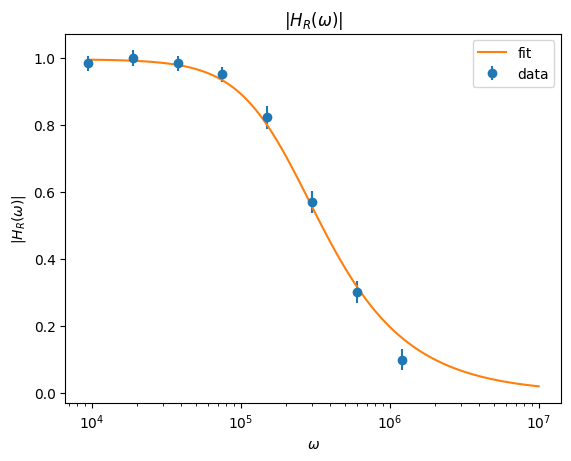

In [6]:
x = np.logspace(4,7,100)
y = mod_HR_f(x,*fit_mod_HR.bval)

plt.title('$|H_R(\omega)|$')
plt.errorbar(ω,modHR,yerr=fit_mod_HR.sigmaY,fmt='o',label='data')
plt.plot(x,y,label='fit')
plt.xscale('log')
plt.ylabel('$|H_R(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

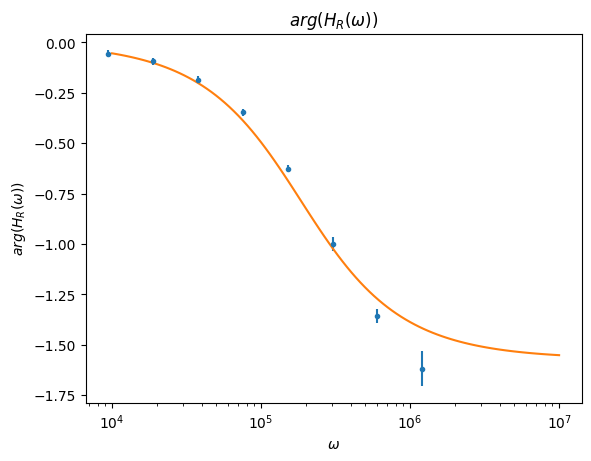

In [7]:
x = np.logspace(4,7,100)
y = arg_HR_f(x,*fit_arg_HR.bval)

plt.title('$arg(H_R(\omega))$')
plt.errorbar(ω,ΦR,yerr=fit_arg_HR.sigmaY,fmt='.')
plt.plot(x,y)
plt.xscale('log')
plt.ylabel('$arg(H_R(\omega))$')
plt.xlabel('$\omega$')
plt.show()

### FUNZIONE DI TRASFERIMENTO $H_L(\omega)$:

- $|H_L(\omega)| = \frac{\sqrt{R_L^2 + \omega^2 L^2}}{\sqrt{(R+R_L)^2 + \omega^2 L^2}}$
- $\angle H_L(\omega) = arctan(\frac{\omega L}{R_L}) - arctan(\frac{\omega L}{R+R_L})$

In [8]:
def mod_HL_f(ω, L): # R noto
    num = np.sqrt(RL**2 + ω**2 * L**2)
    den2 = (R+RL)**2 + ω**2 * L**2
    return num/np.sqrt(den2)

def arg_HL_f(ω,L):
    return np.arctan(ω*L/RL) -np.arctan(ω*L / (R + RL))

In [9]:
modHL = VL/Vin
sigma_modHL = np.sqrt(((VL/(Vin**2))*sigma_Vin)**2 + ((1/(Vin))*sigma_VL)**2)

In [10]:
L_guess =0.04 # usa la resistenza fissata
fit_mod_HL = Interpolazione(ω,modHL,mod_HL_f,sigma_modHL,p0=[L_guess])
fit_arg_HL = Interpolazione(ω,ΦL,arg_HL_f,sigma_ΦL,p0=[L_guess])

print("---------------------------MODULO L-------------------------")
print(fit_mod_HL)
print("---------------------------FASE L-------------------------")
print(fit_arg_HL)

---------------------------MODULO L-------------------------
   
Parameters: [0.04985827] 
Sigma parameters: [0.00186623]

sigmaY: [0.03176202 0.03229581 0.03238474 0.03271739 0.01878281 0.02074291
 0.02227039 0.02262669]

chiquadro ridotto: 0.7
df: 7
pvalue: 99.8%
covariance matrix: [[2.6665167e-06]]    

---------------------------FASE L-------------------------
   
Parameters: [0.04678545] 
Sigma parameters: [0.00464108]

sigmaY: [0.26179939 0.17453293 0.08726646 0.08726646 0.03490659 0.03490659
 0.01745329 0.01745329]

chiquadro ridotto: 3.54
df: 7
pvalue: 83.1%
covariance matrix: [[1.6491294e-05]]    



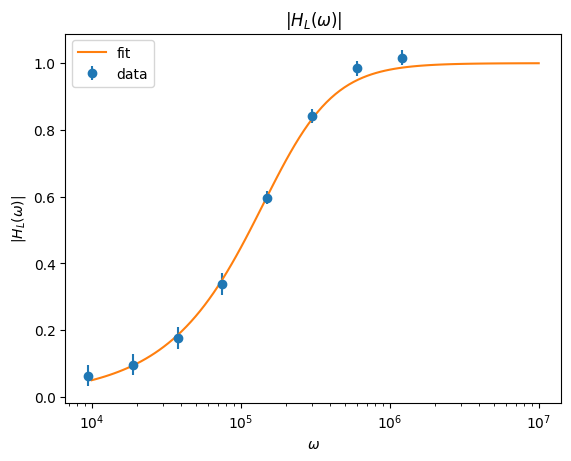

In [11]:
x = np.logspace(4,7,100)
y = mod_HL_f(x,*fit_mod_HL.bval)

plt.title('$|H_L(\omega)|$')
plt.errorbar(ω,modHL,yerr=fit_mod_HL.sigmaY,fmt='o',label='data')
plt.plot(x,y,label='fit')
plt.xscale('log')
plt.ylabel('$|H_L(\omega)|$')
plt.xlabel('$\omega$')
plt.legend()
plt.show()

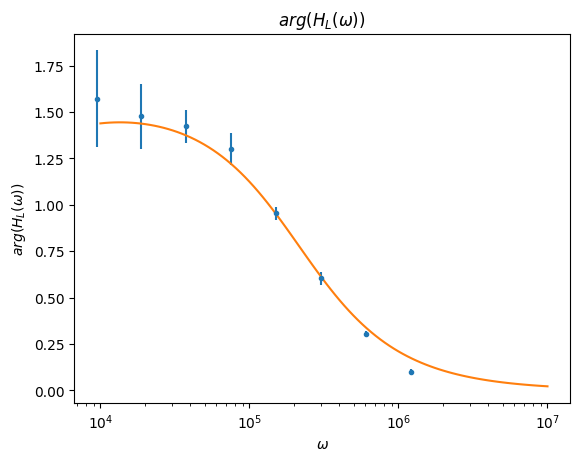

In [12]:
x = np.logspace(4,7,100)
y = arg_HL_f(x,*fit_arg_HL.bval)

plt.title('$arg(H_L(\omega))$')
plt.errorbar(ω,ΦL,yerr=fit_arg_HL.sigmaY,fmt='.')
plt.plot(x,y)
plt.xscale('log')
plt.ylabel('$arg(H_L(\omega))$')
plt.xlabel('$\omega$')
plt.show()